# Optimization Algorithms in Neural Network

## 0 - Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

In [3]:
from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from copy import deepcopy
from testCases import *
from public_tests import *

## 1 - (Batch) Gradient Descent

`Gradient Descent` just computes the gradient with respect to all samples and updates the parameter by moving along the negative gradient direction.

Mathematically, it is expressed as:

$$
W^{[l]} = W^{[l]} - \alpha \cdot \frac{\mathcal{\partial L}}{\partial W^{[l]}}
$$

$$
b^{[l]} = b^{[l]} - \alpha \cdot \frac{\mathcal{\partial L}}{\partial b^{[l]}}
$$

`update_parameters_with_gd` updates parameters using gradient descent

In [4]:
def update_parameters_with_gd(parameters: dict, grads: dict, learning_rate: float):
    """
    Arguments:
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}
    grads: {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    learning_rate: float to denote the learning step size
    
    Returns:
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}
    """
    num_layer = len(parameters.keys()) // 2
    # Gradient descent
    for layer in range(1, num_layer + 1):  # range(a, b) = [a, b)
        parameters[f"W{layer}"] = parameters[f"W{layer}"] - learning_rate * grads[f"dW{layer}"]
        parameters[f"b{layer}"] = parameters[f"b{layer}"] - learning_rate * grads[f"db{layer}"]
    return parameters

`TEST`

In [5]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()
learning_rate = 0.01
parameters = update_parameters_with_gd(parameters, grads, learning_rate)
update_parameters_with_gd_test(update_parameters_with_gd)

All test passed


`Gradient descent` has one variation: `Stochastic gradient descent`, which only updates the parameter with the gradient computed from ONE sample each time.

The high-level workflow is like below:

**Gradient Descent**

```Python
# Step - 1: initialize parameters
parameters = initialize_parameters(layer_size)
for idx in range(0, num_iterations):
    # Step - 2: forward pass
    a, caches = forward_propagation(X, parameters)
    # Step - 3: compute the loss
    loss = compute_loss(a, Y)
    # Step - 4: backward pass
    grads = backward_propagation(a, caches, parameters)
    # Step - 5: update parameters
    parameters = update_parameters(parameters, grads)
```

**Stochastic Gradient Descent**

```Python
# Step - 1: initialize parameters
parameters = initialize_parameters(layer_size)
for idx in range(0, num_iterations):
    for sample in range(0, num_samples])
        # Step - 2: forward pass using single sample
        a, caches = forward_propagation(X[:, sample], parameters)
        # Step - 3: compute the loss using single sample
        loss = loss + compute_loss(a, Y[:, samples])
        # Step - 4: backward pass
        grads = backward_propagation(a, caches, parameters)
        # Step - 5: update parameters
        parameters = update_parameters(parameters, grads)
```

Compared with `gradient descent`, `stochastic gradient descent` often goes faster towards the result but experience severe osciliations. These osciliations are like "noise" because the gradient path is computed against each sample.

## 2 - Mini-Batch Gradient Descent¶

`Gradient descent` and `stochastic gradient descent` are two extremes. Between them, there is `mini-batch gradient descent` algorithm, which updates the parameters based on the gradient computed on a subsample of the entire training set.

The `mini-batch gradient descent` algorithm involves the following steps:

- shuffle X and Y simultaneously
- partition X and Y into multiple subsets
- each time, we just use one subset to compute the gradients and update parameter

`random_mini_batches` generates a list of mini-batches.

In [6]:
def random_mini_batches(X: np.ndarray, Y: np.ndarray, mini_batch_size: int=64):
    """    
    Arguments:
    X: (num_features, num_samples)
    Y: (1, num_samples)
    mini_batch_size: the samples in the mini-batch
    
    Returns:
    mini_batches: [(1st batch X, 1st batch Y), (2nd batch X, 2nd batch Y), ...]
    """
    np.random.seed(0)
    # Get info
    num_samples = X.shape[1]            
    mini_batches = []
    # Step - 1: shuffle X and Y simultaneously
    permutation_idx = np.random.permutation(num_samples).tolist()
    shuffled_X = X[:, permutation_idx]
    shuffled_Y = Y[:, permutation_idx]
    # Step 2 - Partition the X and Y for mini batches
    num_full_batch = num_samples // mini_batch_size
    for batch_idx in range(0, num_full_batch):
        # Get the subset
        mini_batch_X = shuffled_X[:, batch_idx*mini_batch_size:(batch_idx+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, batch_idx*mini_batch_size:(batch_idx+1)*mini_batch_size]
        # Save for final return
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    # Edge case where we the last batch is less than batch_size
    if num_samples % mini_batch_size != 0:
        # Get the last subset
        mini_batch_X = shuffled_X[:, num_full_batch*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_full_batch*mini_batch_size:]
        # Save for final return
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

`TEST`

In [7]:
t_X, t_Y, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(t_X, t_Y, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


`Mini-batch gradient descent` still show osciliation, but less severe than the `stochastic gradient descent`.

## 3 - Momentum

The `mini-batch gradient descent` still has some osciliations. To address such osciliations, we can use `momentum`.

Rather than purely following the direction of the gradient, `momentum` allows us to adjust the moving direction by combining the gradient and velocity.

Mathematically, the momentum method to update the parameter $\theta$ is expressed as:

$$
v_{t+1} = \beta \cdot v_{t} + (1 - \beta) \cdot \frac{\partial \mathcal{L}}{\partial \theta}
$$

$$
\theta_{t+1} = \theta_{t} - \alpha \cdot v_{t+1}
$$

If we replace the $v$ with $W$ or $b$, then the momentum to update the neural network parameters become:

$$
v_{dW^{[l]}}^{(t+1)} = \beta \cdot v_{dW^{[l]}}^{(t)} + (1 - \beta) \cdot dW^{[l](t+1)}
$$

$$
W^{[l](t+1)} = W^{[l](t)} - \alpha \cdot v_{dW^{[l]}}^{(t+1)}
$$

$$
v_{db^{[l]}}^{(t+1)} = \beta \cdot v_{db^{[l]}}^{(t)} + (1 - \beta) \cdot db^{[l](t+1)}
$$

$$
b^{[l](t+1)} = b^{[l](t)} - \alpha \cdot v_{db^{[l]}}^{(t+1)}
$$

The supserscript $^{[l]}$ stands for the index of the layer and $^{(t)}$ stands for the iteration cycle.

`initialize_velocity` initializes velocity with zeros.

In [8]:
def initialize_velocity(parameters: dict):
    """
    Arguments:
    parameters parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}
    
    Returns:
    v: {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    """
    # Get info
    num_layer = len(parameters) // 2
    v = {}
    # Initialize velocity
    for layer in range(1, num_layer + 1):
        v[f'dW{layer}'] = np.zeros(parameters[f'W{layer}'].shape)
        v[f'db{layer}'] = np.zeros(parameters[f'b{layer}'].shape)
    return v

`update_parameters_with_momentum` implements momentum approach

In [9]:
def update_parameters_with_momentum(parameters: dict, grads: dict, v: dict, beta: float, learning_rate: float):
    """
    Arguments:
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}
    grads: {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    v: cumulative {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    beta: float for momentum method
    learning_rate: float for learning step size
    
    Returns:
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}
    v: cumulative {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    """
    # Get info
    num_layer = len(parameters.keys()) // 2
    # Momentum method to update each parameter
    for layer in range(1, num_layer + 1):
        # Update weight matrix
        v[f'dW{layer}'] = beta * v[f'dW{layer}'] + (1 - beta) * grads[f'dW{layer}']
        parameters[f'W{layer}'] = parameters[f'W{layer}'] - learning_rate * v[f'dW{layer}']
        # Update bias term
        v[f'db{layer}'] = beta * v[f'db{layer}'] + (1 - beta) * grads[f'db{layer}']
        parameters[f'b{layer}'] = parameters[f'b{layer}'] - learning_rate * v[f'db{layer}']
    return parameters, v

`TEST`

In [10]:
parameters, grads, v = update_parameters_with_momentum_test_case()
parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
parameters

{'W1': array([[ 1.62544598, -0.61290114, -0.52907334],
        [-1.07347112,  0.86450677, -2.30085497]]),
 'b1': array([[ 1.74493465],
        [-0.76027113]]),
 'W2': array([[ 0.31930698, -0.24990073,  1.4627996 ],
        [-2.05974396, -0.32173003, -0.38320915],
        [ 1.13444069, -1.0998786 , -0.1713109 ]]),
 'b2': array([[-0.87809283],
        [ 0.04055394],
        [ 0.58207317]])}

## 4 - Root Mean Square Propagation (RMSprop)

The core concept of the `RMSprop` is similar to the `gradient descent with momentum` algorithm.

The difference is that `momentum` uses cumulative gradient to guide the next movement whereas the `RMSprop` dynamically changes the learning rate.

Mathematically, it is expressed as follows:

$$
S_{dW^{[l]}}^{(t+1)} = \beta \cdot S_{dW^{[l]}}^{(t)} + (1 - \beta) \cdot dW^{[l](t+1)} \bigodot \cdot dW^{[l](t+1)}
$$

$$
W^{[l](t+1)} = W^{[l](t)} - \frac{\alpha}{\sqrt{S^{(t+1)}_{dW^{[l]}}}} \cdot dW^{[l]}
$$

$$
S_{db^{[l]}}^{(t+1)} = \beta \cdot S_{db^{[l]}}^{(t)} + (1 - \beta) \cdot db^{[l](t+1)} \bigodot \cdot db^{[l](t+1)}
$$

$$
b^{[l](t+1)} = b^{[l](t)} - \frac{\alpha}{\sqrt{S^{(t+1)}_{db^{[l]}}}} \cdot db^{[l]}
$$

The symbol $\bigodot$ stands for the element-wise product.

The intution behind the `RMSprop` is: when the gradient becomes large, the learning rate is dynamically adjusted to be small and thus move "cautiously" to the covergence point.

In [11]:
def update_parameters_with_rmsprop(parameters: dict, grads: dict, S: dict, beta: float, learning_rate: float):
    """
    Arguments:
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}
    grads: {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    S: cumulative {"SdW1": SdW1, "Sdb1": Sdb1, "SdW2": SdW2, "Sdb2": Sdb2, "SdW3": SdW3, "Sdb3", ... "SdWL", SdWL, "SdbL": SdbL}
    beta: float for momentum method
    learning_rate: float for learning step size
    
    Returns:
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}
    S: cumulative {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    """
    # Get info
    num_layer = len(parameters.keys()) // 2
    # Update parameters using RMSprop
    for layer in range(1, num_layer + 1):
        # Update weight parameter
        S[f'dW{layer}'] = beta * S[f'dW{layer}'] + (1 - beta) * grads[f'dW{layer}'] ** 2
        parameters[f'W{layer}'] = parameters[f'W{layer}'] - learning_rate / np.sqrt(S[f'dW{layer}']) * grads[f'dW{layer}']
        # Update bias parameter
        S[f'db{layer}'] = beta * S[f'db{layer}'] + (1 - beta) * grads[f'db{layer}'] ** 2
        parameters[f'b{layer}'] = parameters[f'b{layer}'] - learning_rate / np.sqrt(S[f'db{layer}']) * grads[f'db{layer}']
    return parameters, S

`TEST`

In [12]:
parameters, grads, v = update_parameters_with_momentum_test_case()
parameters, v = update_parameters_with_rmsprop(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
parameters

{'W1': array([[ 1.65596814, -0.64337919, -0.55979453],
        [-1.1045914 ,  0.83378485, -2.26991592]]),
 'b1': array([[ 1.77643454],
        [-0.72958412]]),
 'W2': array([[ 0.35066187, -0.28099315,  1.49373071],
        [-2.02851793, -0.29079443, -0.35243158],
        [ 1.16539222, -1.06826849, -0.14080543]]),
 'b2': array([[-0.90948119],
        [ 0.01059097],
        [ 0.55119244]])}

## 5 - Adaptive Momentum Optimization (Adam)

**Adam = RMSprop + Momentum**

Adam works in the following order:

- calculate the exponentially weighted average of gradient (like `momentum`) and get the corrected gradient (`momentum` did not do so)
- compute the exponentially weighted average of the squares of the gradient (like `adam`) and get the corrected term (`adam` did not do so)
- update the parameter based on previous two steps results

Mathematically:

$$
v_{dW^{[l]}}^{(t+1)} = \beta_1 \cdot v_{dW^{[l]}}^{(t)} + (1 - \beta_1) \cdot dW^{[l](t+1)}
$$

$$
v_{dW^{[l]}}^{(t+1)} = \frac{v_{dW^{[l]}}^{(t+1)}}{(1 - \beta_1^{t+1})}
$$

$$
S_{dW^{[l]}}^{(t+1)} = \beta_2 \cdot S_{dW^{[l]}}^{(t)} + (1 - \beta_2) \cdot dW^{[l](t+1)} \bigodot \cdot dW^{[l](t+1)}
$$

$$
S_{dW^{[l]}}^{(t+1)} = \frac{S_{dW^{[l]}}^{(t+1)}}{(1 - \beta_2^{t+1})}
$$

$$
W^{[l](t+1)} = W^{[l](t)} - \alpha \cdot \frac{v_{dW^{[l]}}^{(t+1)}}{\sqrt{S_{dW^{[l]}}^{(t+1)}}+\epsilon}
$$

Same process for the bias parameters.

`initialize_adam` initializes the parameters related to adam optimization

In [13]:
def initialize_adam(parameters: dict) :
    """
    Arguments:
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}

    Returns: 
    v: cumulative {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    s: cumulative {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    """
    # Get info
    num_layer = len(parameters.keys()) // 2
    v, s = {}, {}
    # Initialize the parameter v and S used for adam algorithm
    for layer in range(1, num_layer + 1):
        v[f'dW{layer}'] = np.zeros(parameters[f'W{layer}'].shape)
        v[f'db{layer}'] = np.zeros(parameters[f'b{layer}'].shape)
        s[f'dW{layer}'] = np.zeros(parameters[f'W{layer}'].shape)
        s[f'db{layer}'] = np.zeros(parameters[f'b{layer}'].shape)
    return v, s

`TEST`

In [14]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
v, s

({'dW1': array([[0., 0., 0.],
         [0., 0., 0.]]),
  'db1': array([[0.],
         [0.]]),
  'dW2': array([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
  'db2': array([[0.],
         [0.],
         [0.]])},
 {'dW1': array([[0., 0., 0.],
         [0., 0., 0.]]),
  'db1': array([[0.],
         [0.]]),
  'dW2': array([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
  'db2': array([[0.],
         [0.],
         [0.]])})

`update_parameters_with_adam` implements adam optimization

In [15]:
def update_parameters_with_adam(parameters: dict, grads: dict, v: dict, s: dict, t: int, learning_rate: float=0.01, beta1: float=0.9, beta2:float=0.999, epsilon: float=1e-8):
    """
    Arguments:
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}
    grads: {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    v: cumulative {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    s: cumulative {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    t: number of current step in adam
    learning_rate: learning step size
    beta1: exponential decay hyperparameter for the first moment estimates 
    beta2: exponential decay hyperparameter for the second moment estimates 
    epsilon: hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}
    v_correct: cumulative {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    s_correct: cumulative {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3", ... "dWL", dWL, "dbL": dbL}
    """
    # Get info
    num_layer = len(parameters) // 2
    v_correct, s_correct = {}, {}
    # Update parameter
    for layer in range(1, num_layer + 1):
        # Update weight parameter
        v[f'dW{layer}'] = beta1 * v[f'dW{layer}'] + (1 - beta1) * grads[f'dW{layer}']
        v_correct[f'dW{layer}'] = v[f'dW{layer}'] / (1 - beta1 ** t)
        s[f'dW{layer}'] = beta2 * s[f'dW{layer}'] + (1 - beta2) * grads[f'dW{layer}'] ** 2
        s_correct[f'dW{layer}'] = s[f'dW{layer}'] / (1 - beta2 ** t)
        parameters[f'W{layer}'] = parameters[f'W{layer}'] - learning_rate * v_correct[f'dW{layer}'] / (np.sqrt(s_correct[f'dW{layer}']) + epsilon)
        # Update bias parameter
        v[f'db{layer}'] = beta1 * v[f'db{layer}'] + (1 - beta1) * grads[f'db{layer}']
        v_correct[f'db{layer}'] = v[f'db{layer}'] / (1 - beta1 ** t)
        s[f'db{layer}'] = beta2 * s[f'db{layer}'] + (1 - beta2) * grads[f'db{layer}'] ** 2
        s_correct[f'db{layer}'] = s[f'db{layer}'] / (1 - beta2 ** t)
        parameters[f'b{layer}'] = parameters[f'b{layer}'] - learning_rate * v_correct[f'db{layer}'] / (np.sqrt(s_correct[f'db{layer}']) + epsilon)
    return parameters, v, s, v_correct, s_correct

`TEST`

In [16]:
parametersi, grads, vi, si = update_parameters_with_adam_test_case()

t = 2
learning_rate = 0.02
beta1 = 0.8
beta2 = 0.888
epsilon = 1e-2

parameters, v, s, vc, sc  = update_parameters_with_adam(parametersi, grads, vi, si, t, learning_rate, beta1, beta2, epsilon)
for k, v in parameters.items():
    print(f'{k}: {v}')

update_parameters_with_adam_test(update_parameters_with_adam)

W1: [[ 1.63942428 -0.6268425  -0.54320974]
 [-1.08782943  0.85036983 -2.2865723 ]]
b1: [[ 1.75854357]
 [-0.74616067]]
W2: [[ 0.33356139 -0.26425199  1.47707772]
 [-2.04538458 -0.30744933 -0.36903141]
 [ 1.14873036 -1.09256871 -0.15734651]]
b2: [[-0.89228024]
 [ 0.02707193]
 [ 0.56782561]]
All test passed


## 6 - Neural Network with Different Optimization Algorithms

### 6.1 - Data Loading and Examination

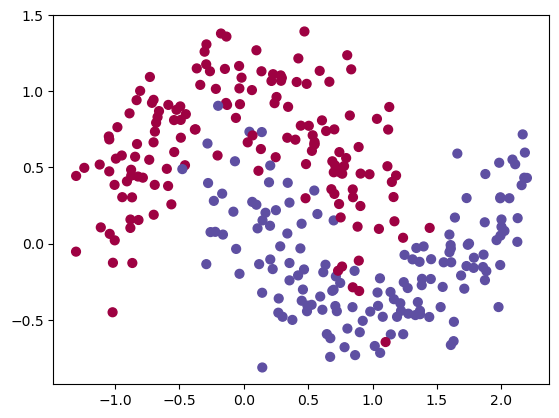

In [17]:
train_X, train_Y = load_dataset()

### 6.2 - Build 3-Layer Neural Network Model

In [49]:
def model(X: np.ndarray, Y: np.ndarray, layers_dims: list[int], optimizer: str, learning_rate: float=0.0007, 
          mini_batch_size: int=64, beta: float=0.9, beta1: float=0.9, beta2: float=0.999,  epsilon: float=1e-8, num_epochs: int=5000,
          decay=None, decay_rate=1):
    """
    Arguments:
    X: (num_features, num_samples)
    Y: (1, num_samples)
    layers_dims: list of integers to denote layer size
    learning_rate: float to denote the learning step size
    mini_batch_size: int to denote the number of samples in each batch
    beta: momentum hyperparameter
    beta1: exponential decay hyperparameter for the past gradients estimates 
    beta2: exponential decay hyperparameter for the past squared gradients estimates 
    epsilon: hyperparameter preventing division by zero in Adam updates
    num_epochs: number of epochs

    Returns:
    parametersparameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3", ... "WL", WL, "bL": bL}
    """
    # Get info
    num_layer = len(layers_dims)
    losses = []
    t, seed = 0, 10                            
    num_samples = X.shape[1]   
    # Learning rate related info
    learning_rate0 = learning_rate
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)
    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    else:
        raise Exception(f'{optimizer} is not supported.')
    
    # Training loop
    for idx in range(num_epochs):
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        loss_total = 0
        for minibatch in minibatches:
            # Extract X and Y from a single batch
            (minibatch_X, minibatch_Y) = minibatch
            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)
            # Compute cost and add to the cost total
            loss_total += compute_cost(a3, minibatch_Y)
            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(
                    parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon
                )
        loss_avg = loss_total / num_samples
        # Adjust the learning rate if necessary
        if decay:
            learning_rate = decay(learning_rate0, idx, decay_rate)  
        # Visualize the training process
        if idx % 1000 == 0 or idx == num_epochs-1:
            print (f"Loss after epoch {idx}: {loss_avg:.8f}")
            print(f"learning rate after epoch {idx}: {learning_rate:.8f}")
        if idx % 100 == 0 or idx == num_epochs-1:
            losses.append(loss_avg)
    # plot the cost
    plt.plot(losses)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    return parameters

### 6.3 - Mini-Batch Gradient Descent

Loss after epoch 0: 0.70240120
Loss after epoch 1000: 0.66764739
Loss after epoch 2000: 0.63421635
Loss after epoch 3000: 0.59896219
Loss after epoch 4000: 0.57183822
Loss after epoch 4999: 0.55040200


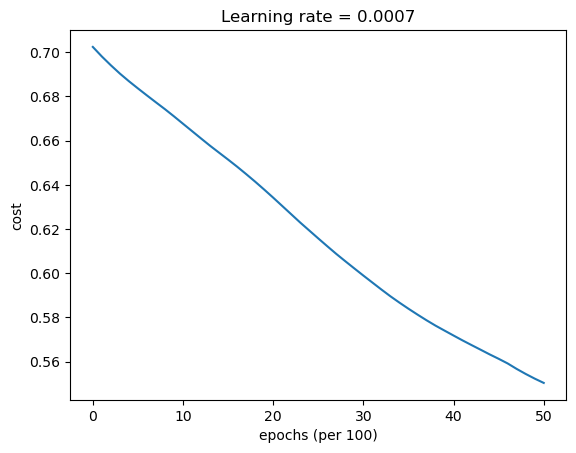

Accuracy: 0.7166666666666667


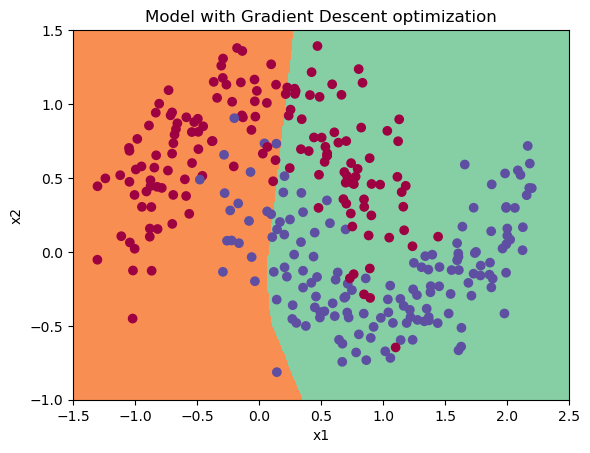

In [43]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 6.4 - Mini-Batch Gradient Descent with Momentum

Loss after epoch 0: 0.70241155
Loss after epoch 1000: 0.66771389
Loss after epoch 2000: 0.63431600
Loss after epoch 3000: 0.59906305
Loss after epoch 4000: 0.57191889
Loss after epoch 4999: 0.55048036


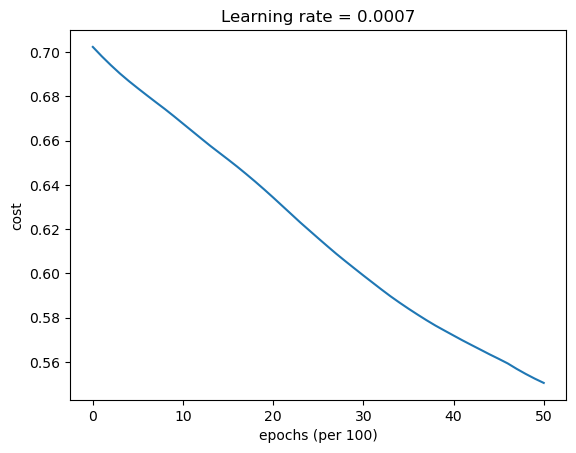

Accuracy: 0.7166666666666667


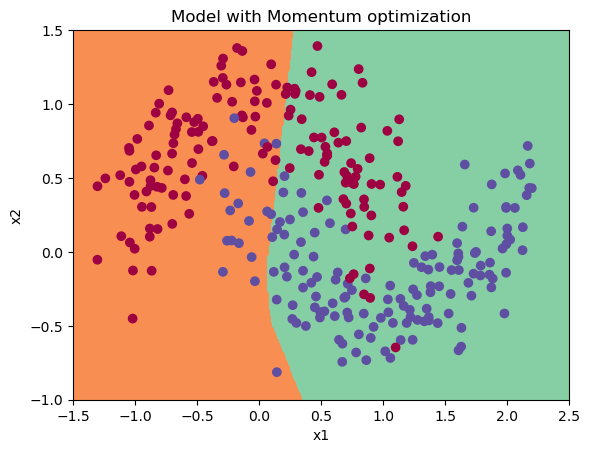

In [44]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 6.5 - Mini-Batch with Adam

Loss after epoch 0: 0.70189868
Loss after epoch 1000: 0.16584516
Loss after epoch 2000: 0.13977345
Loss after epoch 3000: 0.13675566
Loss after epoch 4000: 0.13508597
Loss after epoch 4999: 0.13075686


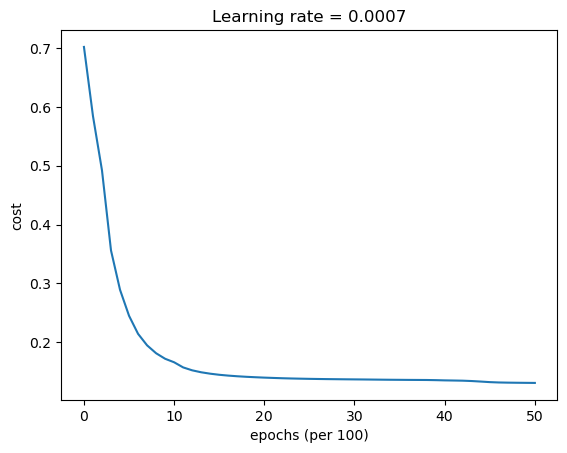

Accuracy: 0.9433333333333334


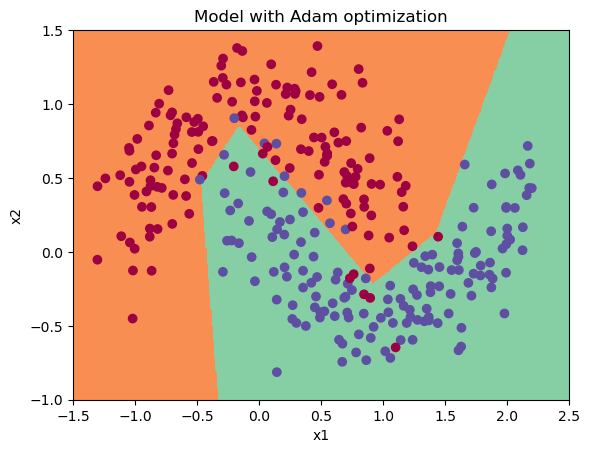

In [45]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 7 - Learning Rate Decay and Scheduling

### 7.1 - Decay with Epoch Number

As the training goes, the learning rate gradually becomes smaller.

Mathematically, it is:

$$
\alpha = \alpha_0 \cdot \frac{1}{1 + r \cdot n}
$$

where $\alpha_0$, $r$, $n$ are base learning rate, decay rate, and current epoch number, correspondingly.

`update_lr` implements learning rate decay

In [46]:
def update_lr(learning_rate0: float, epoch_num: int, decay_rate: float):
    """
    Arguments:
    learning_rate0: float to denote the base learning rate
    epoch_num: int to current number of epoch
    decay_rate: float to denote the decay rate

    Returns:
    learning_rate: float to stand for adjusted learning rate.
    """
    learning_rate = 1/(1+decay_rate*epoch_num) * learning_rate0
    return learning_rate

`TEST`

In [47]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)
epoch_num = 2
decay_rate = 1
learning_rate_2 = update_lr(learning_rate, epoch_num, decay_rate)

print("Updated learning rate: ", learning_rate_2)

update_lr_test(update_lr)

Original learning rate:  0.5
Updated learning rate:  0.16666666666666666
All test passed


`Model`

Loss after epoch 0: 0.70059078
learning rate after epoch 0: 0.10000000
Loss after epoch 1000: 0.66113057
learning rate after epoch 1000: 0.00009990
Loss after epoch 2000: 0.65782585
learning rate after epoch 2000: 0.00004998
Loss after epoch 3000: 0.65598316
learning rate after epoch 3000: 0.00003332
Loss after epoch 4000: 0.65469114
learning rate after epoch 4000: 0.00002499
Loss after epoch 4999: 0.65369891
learning rate after epoch 4999: 0.00002000


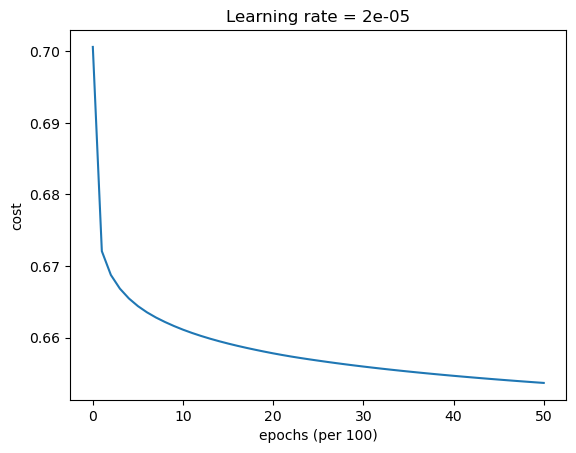

Accuracy: 0.6533333333333333


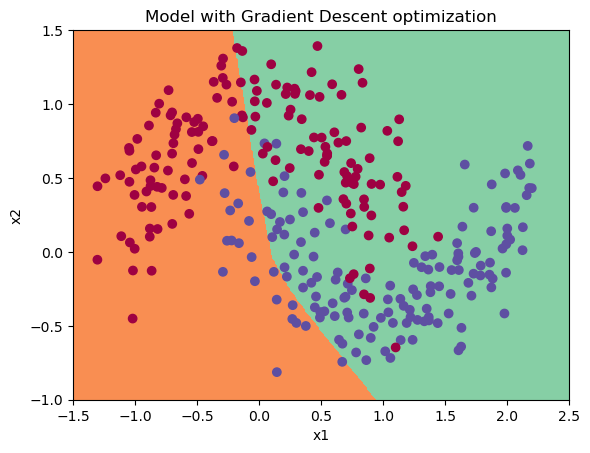

In [50]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=update_lr)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 7.2 - Fixed Interval Scheduling

The learning rate goes towards zero too quickly. To slow down, we can enforce the leanring rate decay to occur after every $E$ epoches.

Mathematically:

$$
\alpha = \alpha_0 \cdot \frac{1}{1 + r \cdot \lfloor{\frac{n}{E}}\rfloor} 
$$

where $\alpha_0$, $r$, $n$, $E$ are base learning rate, decay rate, and current epoch number, specified interval, correspondingly.

`schedule_lr_decay` implements the scheduled decay.

In [51]:
def schedule_lr_decay(learning_rate0: float, epoch_num: int, decay_rate: float, time_interval: int=1000):
    """
    Arguments:
    learning_rate0: float to denote the base learning rate
    epoch_num: int to current number of epoch
    decay_rate: float to denote the decay rate
    time_interval: int to denote the number of epoches where the learning rate decay happen

    Returns:
    learning_rate: float to stand for adjusted learning rate.
    """
    learning_rate =  learning_rate0 * 1 / (1 + decay_rate*np.floor(epoch_num/time_interval))
    return learning_rate

`TEST`

In [52]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)

epoch_num_1 = 10
epoch_num_2 = 100
decay_rate = 0.3
time_interval = 100
learning_rate_1 = schedule_lr_decay(learning_rate, epoch_num_1, decay_rate, time_interval)
learning_rate_2 = schedule_lr_decay(learning_rate, epoch_num_2, decay_rate, time_interval)
print("Updated learning rate after {} epochs: ".format(epoch_num_1), learning_rate_1)
print("Updated learning rate after {} epochs: ".format(epoch_num_2), learning_rate_2)

schedule_lr_decay_test(schedule_lr_decay)

Original learning rate:  0.5
Updated learning rate after 10 epochs:  0.5
Updated learning rate after 100 epochs:  0.3846153846153846
All test passed


### 7.3 - Gradient Descent with Momentum and Learning Rate Decay

Loss after epoch 0: 0.70205502
learning rate after epoch 0: 0.10000000
Loss after epoch 1000: 0.12703675
learning rate after epoch 1000: 0.05000000
Loss after epoch 2000: 0.11761815
learning rate after epoch 2000: 0.03333333
Loss after epoch 3000: 0.11574042
learning rate after epoch 3000: 0.02500000
Loss after epoch 4000: 0.11520501
learning rate after epoch 4000: 0.02000000
Loss after epoch 4999: 0.11502176
learning rate after epoch 4999: 0.02000000


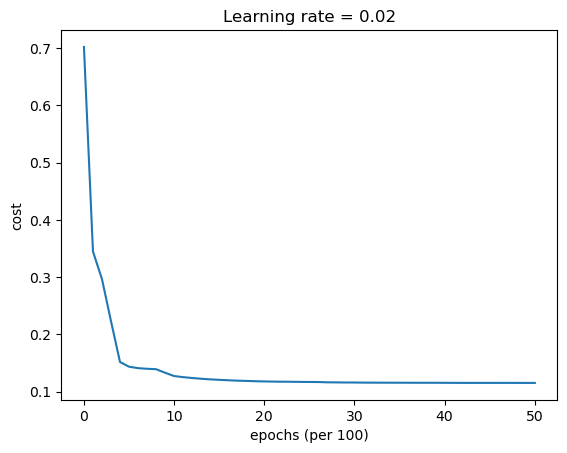

Accuracy: 0.9433333333333334


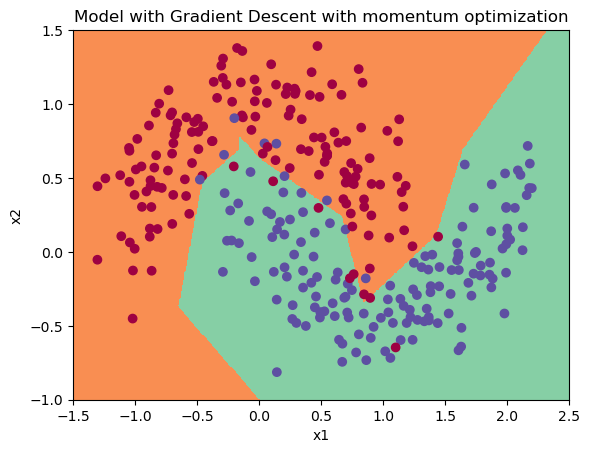

In [53]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "momentum", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent with momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 7.4 - Adam with Learning Rate Decay

Loss after epoch 0: 0.69574292
learning rate after epoch 0: 0.01000000
Loss after epoch 1000: 0.12786228
learning rate after epoch 1000: 0.00500000
Loss after epoch 2000: 0.12630228
learning rate after epoch 2000: 0.00333333
Loss after epoch 3000: 0.12571607
learning rate after epoch 3000: 0.00250000
Loss after epoch 4000: 0.12541372
learning rate after epoch 4000: 0.00200000
Loss after epoch 4999: 0.12522926
learning rate after epoch 4999: 0.00200000


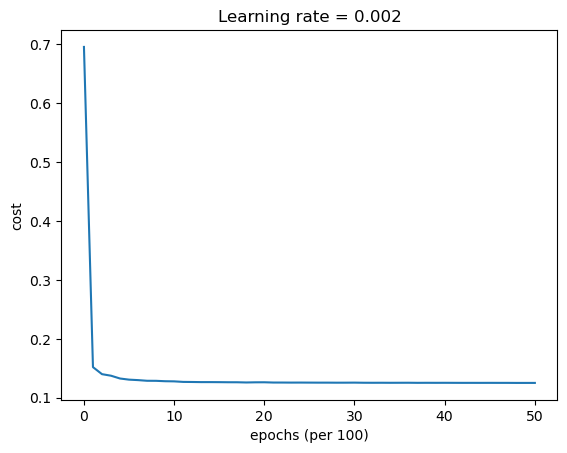

Accuracy: 0.9433333333333334


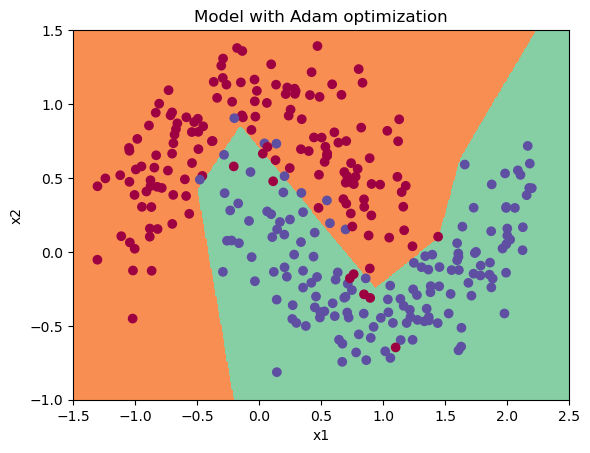

In [54]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam", learning_rate = 0.01, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 8 - Conclusions

## 8.1 - Different Optimization Algorithms

- `Momentum` usually helps to reduce the osciliations.
- `Adam` is usually the best and outperforms the commonly adopted optimization algorithms.

### 8.2 Different Learning Rate Decay

- Naive learning rate decay makes the learning rate quickly go towards zero
- Adapted decay let the learning rate maintain stable during certain number of training cycles and reduce once a while